### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.2.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

In [2]:
data = pd.read_csv(r"../input/clientdat/UTPBatchModified_final.csv",encoding  ='ISO-8859-1')
for i in range(1,18):
    data=data.drop(['ATTRIBUTE_NAME_'+str(i)], axis = 1)
data=data.drop(['NOUN'], axis = 1)
data=data.drop(['MFR_NAME_1'], axis = 1)
data=data.drop(['COMMENTS'], axis = 1)
data=data.drop(['STATUS (CLEANSED/HOLD/ENRICHED)'], axis = 1)
data=data.drop(['Mfr/Vendor_Remarks'], axis = 1)

In [3]:
for i in range(0,(len(data))):
    if (data['STANDARDIZED_VALUE_2'].loc[i][-2:]!='IN' and data['STANDARDIZED_VALUE_2'].loc[i]!='-'):
        data['STANDARDIZED_VALUE_2'].loc[i]=data['STANDARDIZED_VALUE_2'].loc[i]+' IN'
    elif(data['STANDARDIZED_VALUE_2'].loc[i]== '-'):
        data['STANDARDIZED_VALUE_2'].loc[i]=data['STANDARDIZED_VALUE_2'].loc[i]+' IN'
    elif (data['STANDARDIZED_VALUE_2'].loc[i][-2:]=='IN'):
        data['STANDARDIZED_VALUE_2'].loc[i]=data['STANDARDIZED_VALUE_2'].loc[i][:-2]+'-IN'
    elif (data['STANDARDIZED_VALUE_2'].loc[i][-2:]=='MM'):
        data['STANDARDIZED_VALUE_2'].loc[i]=data['STANDARDIZED_VALUE_2'].loc[i][:-2]+'-MM'
    elif (data['STANDARDIZED_VALUE_10'].loc[i][-2:]!='IN' and data['STANDARDIZED_VALUE_10'].loc[i]!='-'):
        data['STANDARDIZED_VALUE_10'].loc[i]=data['STANDARDIZED_VALUE_10'].loc[i]+'_IN'
    elif(data['STANDARDIZED_VALUE_10'].loc[i]== '-'):
        data['STANDARDIZED_VALUE_10'].loc[i]='_IN'
    elif (data['STANDARDIZED_VALUE_10'].loc[i][-2:]=='IN'):
        data['STANDARDIZED_VALUE_10'].loc[i]=data['STANDARDIZED_VALUE_10'].loc[i][:-2]+'_IN'
    elif (data['STANDARDIZED_VALUE_10'].loc[i][-2:]=='MM'):
        data['STANDARDIZED_VALUE_10'].loc[i]=data['STANDARDIZED_VALUE_2'].loc[i][:-2]+'_MM'

In [4]:
test_data=pd.DataFrame()
for i in range(0,len(data)):
    data1 = data.iloc[i].reset_index()
    for j in range(len(data.iloc[i])):
        if(data1[i][j]=='-'):
            data1=data1.drop(j)
    t_data=pd.DataFrame([{'Words' : 'wrd', 'Tags' : 'tg'}])
    t_data=t_data['Words'].append((data1))
    t_data=t_data.drop(0)
    t_data=t_data.drop(1)
    t_data=t_data.rename(columns={'index': 'Tags', i :'Words'})
    t_data=t_data.reset_index()[['Tags','Words']]
    l = [(i+1) for s in range(len(t_data))]
    Sentence=pd.Series(l)
    t_data['Sentence #']=Sentence
    test_data=test_data.append(t_data)
test_data=test_data.reset_index()[['Tags','Words','Sentence #']]
test_data['Tags']=test_data['Tags'].replace({'MFR_NAME_1':'MFR_NAME'})
test_data.shape    

(14144, 3)

In [5]:
df2 = pd.DataFrame({"Tags":['O'], 
                    "Words":['None'], 'Sentence #':[1007]})
test_data=test_data.append(df2)
test_data=test_data.reset_index()[['Tags','Words','Sentence #']]

In [6]:
words = list(set(test_data["Words"].values))
words.append("ENDPAD")
num_words = len(words)
tags = list(set(test_data["Tags"].values))
num_tags = len(tags)
print("Unique words in corpus:", test_data['Words'].nunique())
print("Unique tags in corpus:", test_data['Tags'].nunique())

Unique words in corpus: 3091
Unique tags in corpus: 27


### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Words"].values.tolist(), s["Tags"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(test_data)
sentences = getter.sentences

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

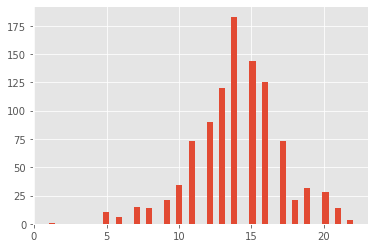

In [10]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 30

X = [[word2idx[w[0]] for w in s] for s in sentences]


y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [12]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=30, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 30)            92760     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 30)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 200)           104800    
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 27)            5427      
Total params: 202,987
Trainable params: 202,987
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
history = model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=32,epochs=40,verbose=1)

Epoch 1/40
26/26 [==============================] - 2s 83ms/step - loss: 2.5072 - accuracy: 0.5142 - val_loss: 1.7862 - val_accuracy: 0.5226
Epoch 2/40
26/26 [==============================] - 2s 61ms/step - loss: 1.6280 - accuracy: 0.5452 - val_loss: 1.5475 - val_accuracy: 0.5556
Epoch 3/40
26/26 [==============================] - 2s 65ms/step - loss: 1.4127 - accuracy: 0.5669 - val_loss: 1.3506 - val_accuracy: 0.5569
Epoch 4/40
26/26 [==============================] - 2s 60ms/step - loss: 1.2205 - accuracy: 0.6095 - val_loss: 1.1869 - val_accuracy: 0.6036
Epoch 5/40
26/26 [==============================] - 2s 59ms/step - loss: 1.0662 - accuracy: 0.6478 - val_loss: 1.0597 - val_accuracy: 0.6556
Epoch 6/40
26/26 [==============================] - 2s 59ms/step - loss: 0.9563 - accuracy: 0.6758 - val_loss: 1.0072 - val_accuracy: 0.6165
Epoch 7/40
26/26 [==============================] - 2s 59ms/step - loss: 0.8878 - accuracy: 0.6910 - val_loss: 0.9147 - val_accuracy: 0.6809
Epoch 8/40
26

### Task 8: Evaluate Named Entity Recognition Model

In [19]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 7ms/step - loss: 0.2061 - accuracy: 0.9363


[0.20605681836605072, 0.9363036155700684]

In [20]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
PARKER-HANNIFINMFR_NAME	MFR_NAME
D31VW004C4NYW3AMFR_P/N	MFR_NAME
D31VW004C4NYW3AMFR_P/N.1	MFR_P/N
HYDRADYNELLC   ADDITIONAL_MFR_VEND_AND_P/N	MFR_P/N.1
CONTROL        MODIFIER	MODIFIER
PILOT OPERATED DIRECTIONAL CONTROLSTANDARDIZED_VALUE_1	STANDARDIZED_VALUE_1
- IN           STANDARDIZED_VALUE_2	STANDARDIZED_VALUE_2
DIN W/O PLUG   STANDARDIZED_VALUE_3	STANDARDIZED_VALUE_3
345 BAR/5000 PSISTANDARDIZED_VALUE_4	STANDARDIZED_VALUE_6
SOLENOID WET PIN SCREW-INSTANDARDIZED_VALUE_7	STANDARDIZED_VALUE_7
76 LPM 20 GPM  STANDARDIZED_VALUE_10	STANDARDIZED_VALUE_10
NFPA           STANDARDIZED_VALUE_11	STANDARDIZED_VALUE_11
4-WAY/3 POSITIONSTANDARDIZED_VALUE_13	STANDARDIZED_VALUE_13
NITRILE        STANDARDIZED_VALUE_14	STANDARDIZED_VALUE_14
CSA            STANDARDIZED_VALUE_16	STANDARDIZED_VALUE_16
VOLTAGE:110/120 V FREQUENCY:50/60 HZSTANDARDIZED_VALUE_17	STANDARDIZED_VALUE_17
92 IN          O	O
92 IN          O	O
92 IN          O	O
92 IN    